# Load dataset

In [1]:
labels = ['AF', 'N']

In [2]:
import os
# disable GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_all_") > -1 :
        filenames.append(filename)

In [3]:
filenames

['test_all_lms.csv',
 'test_all_nlms.csv',
 'test_all_rls.csv',
 'train_all_lms.csv',
 'train_all_nlms.csv',
 'train_all_rls.csv']

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from keras.utils.np_utils import to_categorical

In [6]:
train_lms_df = pd.read_csv(dataset_folder + "train_all_lms.csv", header=None)
train_nlms_df = pd.read_csv(dataset_folder + "train_all_nlms.csv", header=None)
train_rls_df = pd.read_csv(dataset_folder + "train_all_rls.csv", header=None)

test_lms_df = pd.read_csv(dataset_folder + "test_all_lms.csv", header=None)
test_nlms_df = pd.read_csv(dataset_folder + "test_all_nlms.csv", header=None)
test_rls_df = pd.read_csv(dataset_folder + "test_all_rls.csv", header=None)

## Dataset AFDB
Dataset AFDB terdiri dari 301 kolom, dimana kolom ke 301 merupakan katerori/class.

In [6]:
train_lms_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.833959,0.207166,-0.397568,-0.668535,-0.634414,-0.546541,-0.427179,-0.324028,-0.294325,-0.293510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000066,0.778843,0.197246,-0.654896,-0.752678,-0.701556,-0.627424,-0.488307,-0.260185,-0.056891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.674980,0.488569,-0.049251,-0.626870,-0.884725,-0.843853,-0.636132,-0.384400,-0.250431,-0.111275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.469257,0.181136,-0.403827,-0.702582,-0.506684,-0.337331,-0.155410,-0.136795,-0.138124,-0.139822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.784277,0.635830,0.161309,-0.408053,-0.841024,-0.476364,-0.281549,-0.145791,-0.042997,-0.015485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_lms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22440 entries, 0 to 22439
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 51.5 MB


In [8]:
test_lms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9408 entries, 0 to 9407
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 21.6 MB


## Dataset Augmentation

In [7]:
denoised = 'nlms' # isi dengan 'lms', 'nlms', 'rls' untuk memilih sumber dataset dari hasil denoising tsb.

train_df = train_lms_df if denoised == 'lms' else train_nlms_df if denoised == 'nlms' else train_rls_df
test_df = test_lms_df if denoised == 'lms' else test_nlms_df if denoised == 'nlms' else test_rls_df

In [8]:
ecg_df = pd.concat([train_df, test_df])

In [9]:
ecg_df[300]=ecg_df[300].astype(int)
equilibre=ecg_df[300].value_counts()

print(equilibre)

1    16804
0    15044
Name: 300, dtype: int64


In [10]:
# sampling and resampling dataset

from sklearn.utils import resample
n_samples = 30000 
random_states = [123, 124]

dfs = []

for i in range(len(equilibre)):
    dfs.append(ecg_df[ecg_df[300]==i])
    dfs[i]=resample(dfs[i],replace=True,n_samples=n_samples,random_state=random_states[i])

ecg_df=pd.concat(dfs)

In [11]:
ecg_df[300]=ecg_df[300].astype(int)
equilibre=ecg_df[300].value_counts()

print(equilibre)

1    30000
0    30000
Name: 300, dtype: int64


## Split dataset

In [13]:
target_train = ecg_df[300]
y = to_categorical(target_train)

X = ecg_df.iloc[:,:300].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.15, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51000, 300), (9000, 300), (51000,), (9000,))

In [26]:
pd.DataFrame(np.hstack((X_test, np.expand_dims(y_test, 1)))).to_csv("test_afdb.csv", index=None, header=None)

## Building Convolutional Neural Network

- Import Keras library

In [17]:

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras

- Buat CNN Model dengan aritektur network : 
`CONV-POOL-CONV-POOL-CONV-POOL-FC`
- CONV : 1D Convolutional Layer
- POOL : MAX Pooling Layer
- FC   : Dense Layer + Activation

In [18]:
def cnn_model(max_len):
    
    model = Sequential()
    
    model.add(Conv1D(filters=64,
                     kernel_size=5,
                     activation='relu',
                     input_shape=(max_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    # Fully Connected layer (FC)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(2, 
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

- sekarang kita akan melakukan proses training model dengan memanfaatkan `.fit()` pada model yang kita buat diatas.
- selain itu kita gunakan juka teknik `EarlyStoping()` untuk menghentikan proses training jika terjadi divergensi pada validation data yang diakibatkan oleh overfitting. 
- pada `EarlyStoping()` kita gunakan parmeter `patience=8` yang artinya jika proses training untuk 8 epoch tidak terjadi peningkatan maka hentikan proses training.

In [19]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      shuffle=True,
                      validation_data=(x_val,y_val))
    model_.load_weights('best_model.h5')
    return hist 

### Train Model CNN

- Prepare training set dan test set

In [20]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

- jalankan proses training dengan `EPOCH` sebanyak 16 dan `BATCH_SIZE` sebesar 32

In [21]:
max_len = X_train.shape[1]  

EPOCHS = 16
BATCH_SIZE = 128

model = cnn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 296, 64)           384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 296, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 148, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 146, 64)           12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 146, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 71, 64)            12352     
__________

## Save model

In [22]:
model.save("CNN_Classification_model_%s.h5" % denoised)

# Evaluate Model

- Plot Accuracy vs Epochs
- Plot Loss vs Epochs
- Plot Confusion Matrix

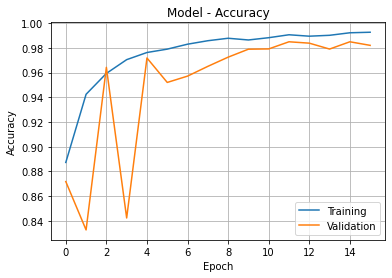

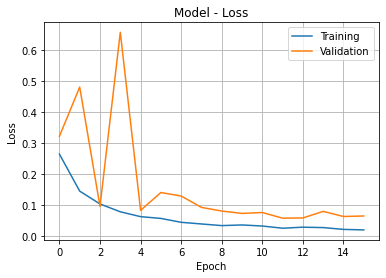

In [23]:
def evaluate_model(history, X_test, y_test):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid()
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()

evaluate_model(history, X_test, y_test)    

- Dari hasil diatas kita bisa melihat jika akurasi training set = 0.99, sedangkan untuk akurasi validation set = 0.97
- Untuk plot loss training set = 0.01 sedangkan untuk loss validation set = 0.13

In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

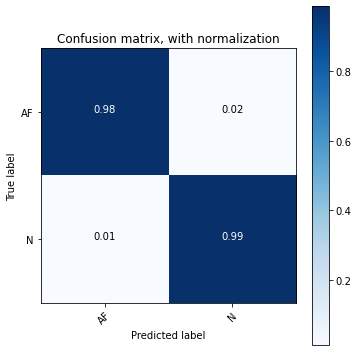

In [25]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix, with normalization')


- dari hasil plot confusion matrix, dapat dilihat tiap kelas memiliki banyak TRUE POSITIVE predicted data
- semakin gelap kebiruan menunjukan banyaknya hasil predicted label untuk true label tersebut

In [26]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

              precision    recall  f1-score   support

          AF       0.99      0.98      0.98      4445
           N       0.98      0.99      0.99      4555

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000



- Jika kita lihat, nilai report untuk seluruh klas juga bagus, 
- Nilai recall dan precission juga tinggi, menunjukan model mampu memprediksi data dengan baik untuk seluruh data pada class tersebut 

## Plot Histogram Data

In [31]:
def plot_hist(class_number, min_, size, fs=250):
    # filter data berdasarkan class_number 
    ECG=train_df.loc[train_df[300]==class_number].values
    
    # scale tm value (*1000) agar bisa ditampilkan dalam satuam (ms)
    tm = np.arange(ECG.shape[1], dtype='float') / fs * 1000
    
    # ambil data hanya pada kolom `min_` sampai `size`
    # convert ke 1D array
    ECG=ECG[:,min_:size]
    ECG_flatten=ECG.flatten()
    
    # generate time data untuk tiap kolom sample, 
    # ulang sebanyak ECG.shape[0]
    times = np.tile(tm[min_:size], ECG.shape[0]) 

    # plot sebagai 2D histogram
    plt.hist2d(times, ECG_flatten, bins=(80,80), cmap=plt.cm.jet)
    plt.title("2D histogram on class " + str(class_number))
    plt.xlabel("Time (ms)")
    plt.ylabel("Normalized Value")
    plt.show()

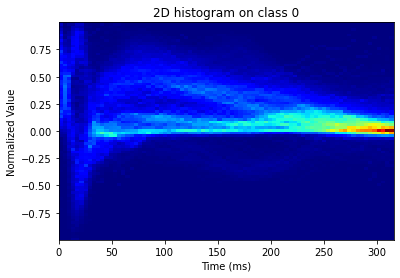

In [32]:
plot_hist(class_number=0, min_=0, size=80)

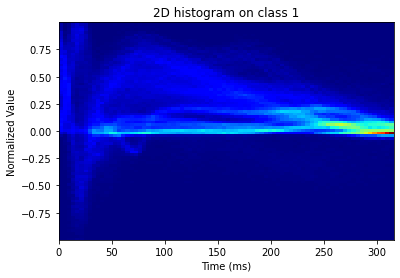

In [33]:
plot_hist(class_number=1, min_=0, size=80)